In [1]:

# After 500 time steps the game automaticly terminates

import time
import random
import heapq as hp
import gym
import numpy as np
from keras import backend as K
import keras
from collections import deque
from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution2D, Dense, Flatten, merge, MaxPooling2D, Input, AveragePooling2D, Lambda, merge, Activation, Embedding
from keras.optimizers import SGD, Adam, rmsprop

import tensorflow as tf

config =tf.ConfigProto(
        device_count={'GPU':0}
)
sess=tf.Session(config=config)

K.set_session(sess)

np.random.seed(10)
EPISODES = 1000


class DQNAgent:
    def __init__(self, state_size, action_size,epsilon=1.0 ,epsilon_decay=0.98,gamma=0.999, num_atoms = 51, min_rd=-5, max_rd=5):# num_atoms = 51 since it's C51
        self.state_size = state_size
        self.action_size = action_size
        self.memory = {}
        self.pqt=[]
        self.gamma = gamma   # discount rate 0.95
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = 0.01   # epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay  #0.99
        self.learning_rate = 0.001  # the learning rate:0.001
        self.num_atoms = num_atoms
        self.min_rd=min_rd
        self.max_rd=max_rd
        self.sep=(self.max_rd-self.min_rd)/(self.num_atoms-1)
        self.theQsa = np.array([self.min_rd + self.sep*i for i in range(self.num_atoms)])
        self.model = self._build_model()
        self.pev_model=self._build_model()
        self.pev_model.set_weights(self.model.get_weights())
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        state_input = Input(shape=(self.state_size,))
        l1 = Dense(24, input_dim=self.state_size, activation='relu')(state_input)
        l2 = Dense(24, activation='relu')(l1)
        
        distribution_list = []
        for i in range(action_size):
            distribution_list.append(Dense(self.num_atoms, activation='softmax')(l2))

        model = Model(input=state_input, output=distribution_list)

        adam = Adam(lr=self.learning_rate)
        model.compile(loss='categorical_crossentropy',optimizer=adam)
        
        return model
    '''    
    def compute(self, state, model):       
        
        self.theQsa = self.max_rd * np.random.sample((self.num_atoms,)) - self.min_rd
        pQs = model.predict([state, np.reshape(self.theQsa, [1, self.num_atoms]))
        Qsa = [np.dot(self.theQsa, pQsa) for pQsa in pQs]
        return np.argmax(Qsa)
    '''        

    def remember(self, eps, state, action, reward, next_state, done):
        
     
        pQs = self.pev_model.predict(next_state)
        Qsa = [np.dot(self.theQsa, pQsa[0]) for pQsa in pQs]
        
        
        cort_rwd=(reward + self.gamma *Qsa[np.argmax(Qsa)])
        
        pQs = self.model.predict(state)
        Qsa = [np.dot(self.theQsa, pQsa[0]) for pQsa in pQs]
       
        
        prd_rwd = Qsa[np.argmax(Qsa)]  
        
        hp.heappush(self.pqt,-abs(float(cort_rwd - prd_rwd)))
        self.memory[-abs(float(cort_rwd - prd_rwd))]=(state, action, reward, next_state, done)
        
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        pQs = self.model.predict(state)
        Qsa = [np.dot(self.theQsa, pQsa[0]) for pQsa in pQs]
        
        return np.argmax(Qsa) # returns action
    
    def replay(self, batch_size):
        
        for _ in range(batch_size):
            
            state, action, reward, next_state, done = self.memory[hp.heappop(self.pqt)]
            if done:
                
              
                kcac = (reward-self.theQsa[0])/self.sep
                TPQsa = np.zeros(self.num_atoms)
                TPQsa[int(kcac)] = 1
                target = TPQsa
            if not done:
        
                pQs = self.pev_model.predict(next_state)
                Qsa = [np.dot(self.theQsa, pQsa[0]) for pQsa in pQs]
                pQ = pQs[np.argmax(Qsa)][0]
                target = np.copy(pQ)
                if ((self.theQsa[0]-reward)/self.gamma)==self.theQsa[0] :
                    target = np.copy(pQ)
                elif ((self.theQsa[0]-reward)/self.gamma)<self.theQsa[0]:
                    kcac = (self.theQsa[0]-((self.theQsa[0]-reward)/self.gamma))/self.sep
                    for i in range(self.num_atoms-int(kcac)):
                        target[i+int(kcac)]=pQ[i]
                else:
                    kcac = -(self.theQsa[0]-((self.theQsa[0]-reward)/self.gamma))/self.sep
                    for i in range(self.num_atoms-int(kcac)):
                        target[i]=pQ[i+int(kcac)]
    
           
            target_f = self.model.predict(state)
           # print(np.shape(target_f))
            target_f[action][0] = target
            #print(np.shape(self.theQsa))
            
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    time_start=time.time()
    
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 64
    vally=0
    rslt=[]
    ep=[]
    
    for e in range(EPISODES):
        
        done=False
        state = env.reset()  # It's obdervation 'o'
        state = np.reshape(state, [1, state_size]) # Encapsulating whole thing into and array i.e [[1,12,2,3]]
        for t in range(500):      
            
            env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = 0 if t==499 or not done else -1
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(e, state, action, reward, next_state, done)
            state = next_state
              
            if done and not t==499:
                agent.pev_model.set_weights(agent.model.get_weights())
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, t, agent.epsilon))
                break
        rslt.append(t)
        if t>=499 : 
            vally+=1
            ep.append(e)
            print("Time for which pole stand:",t,vally)
            if len(ep)>2:
                
                if list(range(3))==[smt-ep[-3] for smt in ep[-3:]]:
                    print("Done after episode:",e-1)
                    break
                 
        if len(agent.pqt) > batch_size:
            agent.replay(batch_size)
    end_time=time.time()
    print(end_time-time_start)
        # if e % 10 == 0:
#     agent.save("./save/cartpole-dqn.h5")

Using TensorFlow backend.
/home/aditya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


episode: 0/1000, score: 34, e: 1.0
episode: 1/1000, score: 13, e: 1.0
episode: 2/1000, score: 10, e: 1.0
episode: 3/1000, score: 16, e: 1.0
episode: 4/1000, score: 12, e: 0.98
episode: 5/1000, score: 21, e: 0.98
episode: 6/1000, score: 16, e: 0.98
episode: 7/1000, score: 11, e: 0.96
episode: 8/1000, score: 20, e: 0.96
episode: 9/1000, score: 10, e: 0.96
episode: 10/1000, score: 15, e: 0.96
episode: 11/1000, score: 19, e: 0.96
episode: 12/1000, score: 14, e: 0.94
episode: 13/1000, score: 23, e: 0.94
episode: 14/1000, score: 19, e: 0.94
episode: 15/1000, score: 90, e: 0.92
episode: 16/1000, score: 11, e: 0.9
episode: 17/1000, score: 71, e: 0.9
episode: 18/1000, score: 12, e: 0.89
episode: 19/1000, score: 10, e: 0.87
episode: 20/1000, score: 16, e: 0.87
episode: 21/1000, score: 39, e: 0.87
episode: 22/1000, score: 16, e: 0.85
episode: 23/1000, score: 11, e: 0.85
episode: 24/1000, score: 11, e: 0.85
episode: 25/1000, score: 16, e: 0.85
episode: 26/1000, score: 9, e: 0.83
episode: 27/1000, 

In [2]:
def policy_evaluation(env,agent1):
    avg=0
    agent1.epsilon=0
    for i in range(100):
        env.seed(85*i)
        state=env.reset()
        state=np.reshape(state,[1,agent1.state_size])
        action=agent1.act(state)
        nxt_state, reward, done, info = env.step(action)
        net_r=1
        while not done:
            env.render
            net_r+=reward
            state=nxt_state
            state=np.reshape(state, [1,agent1.state_size])
            action=agent1.act(state)
            nxt_state, reward, done, info = env.step(action)
            #print(nxt_state, reward, done)
        avg+=net_r
        rslt.append(net_r)
        print("Reward for {} episode: {}".format(i,net_r))
    print("Avg reward: ",avg/(i+1) )
    env.close()

In [3]:
policy_evaluation(env,agent)

Reward for 0 episode: 500.0
Reward for 1 episode: 500.0
Reward for 2 episode: 500.0
Reward for 3 episode: 500.0
Reward for 4 episode: 500.0
Reward for 5 episode: 500.0
Reward for 6 episode: 500.0
Reward for 7 episode: 500.0
Reward for 8 episode: 500.0
Reward for 9 episode: 500.0
Reward for 10 episode: 500.0
Reward for 11 episode: 500.0
Reward for 12 episode: 500.0
Reward for 13 episode: 500.0
Reward for 14 episode: 500.0
Reward for 15 episode: 500.0
Reward for 16 episode: 500.0
Reward for 17 episode: 500.0
Reward for 18 episode: 500.0
Reward for 19 episode: 500.0
Reward for 20 episode: 500.0
Reward for 21 episode: 500.0
Reward for 22 episode: 500.0
Reward for 23 episode: 500.0
Reward for 24 episode: 500.0
Reward for 25 episode: 500.0
Reward for 26 episode: 500.0
Reward for 27 episode: 500.0
Reward for 28 episode: 500.0
Reward for 29 episode: 500.0
Reward for 30 episode: 500.0
Reward for 31 episode: 500.0
Reward for 32 episode: 500.0
Reward for 33 episode: 500.0
Reward for 34 episode: 5

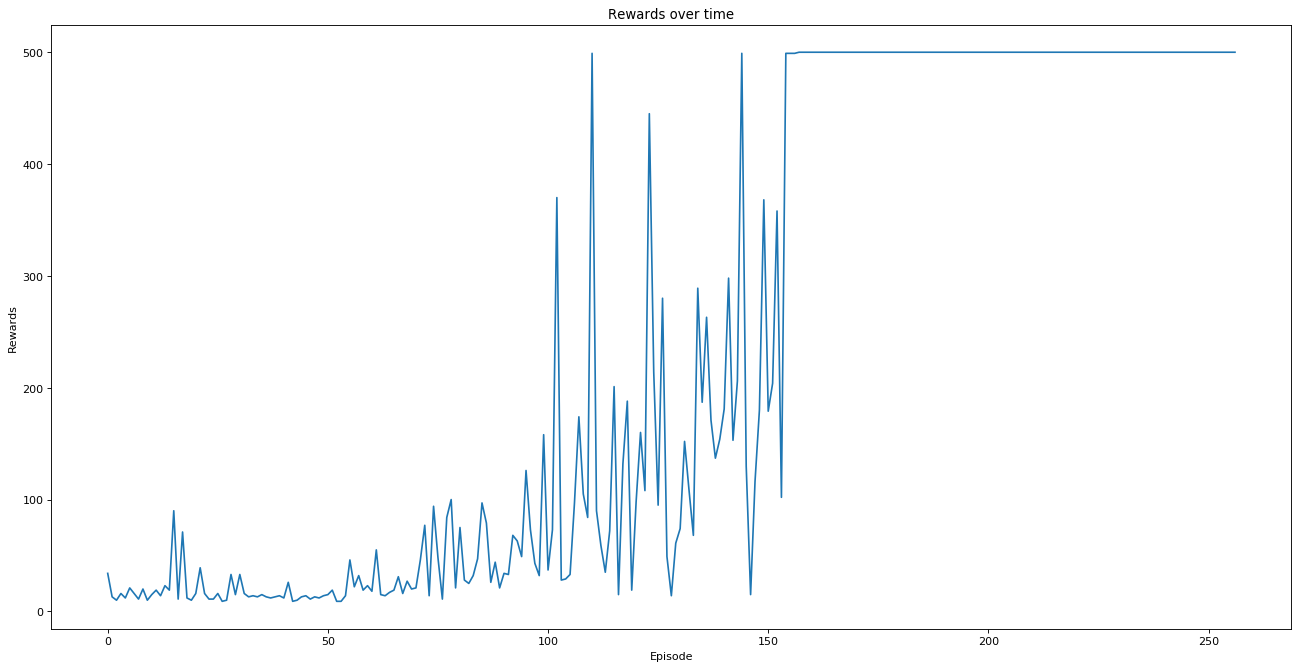

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rslt)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards over time')
#plt.savefig("./cartpole_ddqn.png")
plt.show()